In [172]:
%matplotlib inline
import scipy as sp
from scipy import io, stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['legend.fancybox'] = False

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import model_selection, linear_model, svm, gaussian_process
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

### function defs

In [107]:
def get_preproc_datasets(baby_feat, baby_pma, baby_id, org_feat_stacked, org_age_stacked, org_id_stacked, 
                         train_set='baby', feat_cols=None, age_range=None):

    age_inds_baby = get_age_inds(baby_pma, age_range)
    age_inds_org = get_age_inds(org_age_stacked, age_range)
    
    if feat_cols is None:
        feat_cols = range(baby_feat.shape[1])
    
    if train_set is 'baby':
        train_x = baby_feat[age_inds_baby,:][:,feat_cols]
        train_y = baby_pma[age_inds_baby]
        train_id = baby_id[age_inds_baby]
        test_x = org_feat_stacked[age_inds_org,:][:,feat_cols]
        test_y = org_age_stacked[age_inds_org]
        test_id = org_id_stacked[age_inds_org]
        
    elif train_set is 'organoid':
        train_x = org_feat_stacked[age_inds_org,:][:,feat_cols]
        train_y = org_age_stacked[age_inds_org]
        train_id = org_id_stacked[age_inds_org]
#         test_x = baby_feat[age_inds_baby,:][:,feat_cols]
#         test_y = baby_pma[age_inds_baby]
#         test_id = baby_id[age_inds_baby]
        test_x = baby_feat[:,feat_cols]
        test_y = baby_pma
        test_id = baby_id
    
    else: 
        print('BABY OR BRAINBALL??? \n(baby or organoid)')
        return None,None,None,None,None,None

    return train_x, train_y, train_id, test_x, test_y, test_id
    
def get_age_inds(age_vec, age_range):
    # return indices that satisfy the required age range
    if age_range is None:
        age_inds = np.arange(len(age_vec))
    else:
        age_inds = np.logical_and(age_vec>age_range[0], age_vec<age_range[1])
    return age_inds

def print_model_weights(model, feat_names):    
    print('------- Feature Weights: ------')
    print('Constant: : %.5f' %model.intercept_)
    for i in range(len(feat_names)):
        print(feat_names[i] +': %.5f' %model.coef_[i])
    
    
def predict_on_testset(model, x_test, y_test, figsize=(6,3)):
    y_pred = model.predict(x_test)
    
    # get line of best fit between test and predicted
    pparams = np.polyfit(y_test, y_pred, deg=1)    
    plt.figure(figsize=figsize)

    # plot prediction mean & std
    plot_mean_pred(model.predict(x_test), y_test)
    plt.plot(y_test, y_pred, '.', color=CKEYS[0], alpha=0.5)
    YL = plt.ylim()
    plt.plot(y_test, y_test, '--k', label='Perfect Prediction', alpha=1)
    plt.xlabel('Actual Age (Weeks)')
    plt.ylabel('Predicted Age (Weeks)')
    plt.ylim(YL);
    plt.legend()
    
    print('---')
    # The mean squared error
    print("Mean squared error: %.3f" % mean_squared_error(y_test, y_pred))
    # R2 score: 1 is perfect prediction
    print('R2 score: %.3f' % r2_score(y_test, y_pred))
    # Correlation
    print('Correlation Coef: %.2f, P-Value: %.5f' % sp.stats.pearsonr(y_test, y_pred))
    

def plot_mean_pred(pred_y, test_y, alpha=0.05):
    #alpha=0.05/len(pred_y)
    print(alpha)
    ages = np.unique(test_y)
    pred_mean = np.zeros_like(ages)
    pred_std = np.zeros_like(ages)
    sig_x = []
    for ind, age in enumerate(ages):
        # not correcting for MC
        if sp.stats.ttest_1samp(pred_y[np.where(test_y == age)[0]], age)[1]>alpha:
            sig_x.append(age)
        
        pred_mean[ind] = np.mean(pred_y[np.where(test_y == age)[0]])
        pred_std[ind] = np.std(pred_y[np.where(test_y == age)[0]])

    plt.fill_between(ages, pred_mean-pred_std, pred_mean+pred_std, facecolor=[0,0,0,0.2], edgecolor=[0,0,0,0])
    plt.plot(ages, pred_mean, '.-',color=CKEYS[0], ms=12, label='Mean Prediction')
    plt.plot(sig_x, np.ones_like(sig_x)*plt.ylim()[1], 'k*')
    plt.xlabel('Actual Age (Weeks)')
    plt.ylabel('Predicted Age (Weeks)')

### load data & preprocess

(0, 1000)

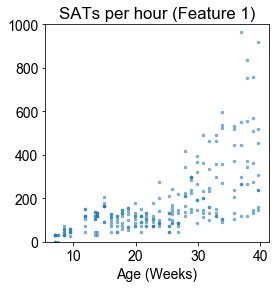

In [3]:
fig_saveout = '/Users/rdgao/Dropbox/Research/Reports/2018 - CorticoidOscillation/CorticoidFigs/figures/raw_pdfs/'

# organoid data
org_feat_file = '/Users/rdgao/Documents/data/Muotri/Pri_Corticoids/ctc_EMAfeatures.mat'
org_data = io.loadmat(org_feat_file, squeeze_me=True)
org_feat = org_data['ctc_EMAfeatures']
org_age = org_data['dayVec']

# stack organoid features, original dimensions are (session x wells x feature)
org_feat_stacked = np.reshape(org_feat, (np.prod(org_feat.shape[:2]), org_feat.shape[2]))

# drop rows with nans in the feature
clean_inds = np.where(~np.isnan(org_feat_stacked).any(axis=1))[0]
org_feat_stacked = org_feat_stacked[clean_inds,:]
org_age_stacked = np.repeat(org_age, org_feat.shape[1])[clean_inds]
org_id_stacked = np.reshape(np.matmul(np.ones((org_feat.shape[0],1)), np.expand_dims(np.arange(8),0)), -1)[clean_inds]

# baby data
baby_feat_file = '/Users/rdgao/Documents/data/Muotri/InfantEEGFeatures/preterm_features.mat'
baby_data = sp.io.loadmat(baby_feat_file, squeeze_me=True)
baby_data.keys()
baby_feat = baby_data['features_fullepoch']

# split age array into columns
baby_id, baby_pma, baby_ema = baby_data['age'].T

# only want certain columns of features
feat_cols = np.array([6,7,8,9,10,11,12,13,14,19,20,21,22])
feat_names = ['SATs per hour',
'RMS SAT duration',
'SAT duration (50%)',
'SAT duration (5%)',
'SAT duration (95%)',
'RMS Inter-SAT Duration',
'Inter-SAT duration (50%)',
'Inter-SAT duration (5%)',
'Inter-SAT duration (95%)',
'Relative Delta Power',
'Relative Theta Power',
'Relative Alpha Power',
'Relative Beta Power']

plt.figure(figsize=(4,4))
feat_ind = 0
pparams = np.polyfit(baby_pma, baby_feat[:,feat_cols[feat_ind]], deg=1)
plt.plot(org_age_stacked, org_feat_stacked[:,feat_cols[feat_ind]], '.', ms=5,alpha=0.5,label='Organoid');
# plt.plot(baby_pma, baby_feat[:,feat_cols[feat_ind]],'.k', ms=5, alpha=0.2, label='Neonate');
# plt.plot([25., 38.], np.array([25., 38.])*pparams[0]+pparams[1], 'r-', lw=3)
plt.xlabel('Age (Weeks)')
plt.title(feat_names[feat_ind] + ' (Feature %i)'%(feat_ind+1))
plt.ylim([0, 1000])
#plt.legend(fontsize=12)
#plt.xlim([24, 40])
#plt.savefig(fig_saveout + '6_' + feat_names[feat_ind] + '.pdf', bbox_inches = 'tight')
#plt.savefig('/Users/rdgao/Dropbox/Research/Reports/2018 - KIBMTalk - CorticoidOscillation/' + '6_' + feat_names[feat_ind] + '.pdf', bbox_inches = 'tight')

### visualize all features

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


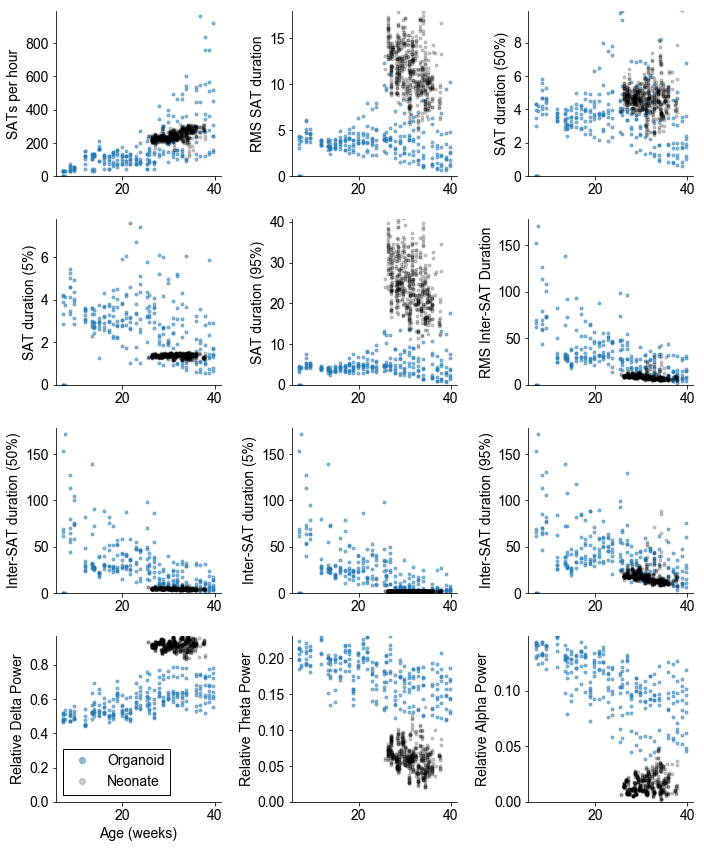

In [4]:
plt.figure(figsize=(10,12))
for ind, ft in enumerate(feat_cols[:-1]):
    plt.subplot(4,3,ind+1)
    plt.plot(org_age_stacked,org_feat_stacked[:,ft], '.', alpha=0.5, label='Organoid')
    plt.plot(baby_pma, baby_feat[:,ft],'.k', alpha=0.2, label='Neonate');
    plt.ylim([0, np.max([np.percentile(org_feat_stacked[:,ft], 99), np.percentile(baby_feat[:,ft], 99)])])    
    plt.ylabel(feat_names[ind])
    plt.gca().spines['right'].set_visible(False);plt.gca().spines['top'].set_visible(False);
    
plt.subplot(4,3,10)
plt.xlabel('Age (weeks)')
plt.legend(shadow=False, framealpha=1, edgecolor='k', markerscale=2)
plt.tight_layout()
plt.savefig(fig_saveout + 'supp_all_features.pdf', bbox_inches = 'tight')

### resampled correlation & linear fits

In [188]:
# setting up data
train_set = 'baby'
feat_subset = np.arange(len(feat_names)-1)
#feat_subset = [0,8]
print('Training on: ' + train_set)

# define training data & id
baby_x, baby_y, baby_id, org_x, org_y, org_id = get_preproc_datasets(
    baby_feat, baby_pma, baby_id, 
    org_feat_stacked, org_age_stacked, org_id_stacked,
    train_set=train_set, feat_cols=feat_cols[feat_subset], age_range=(25,38))

N_split = 100
leave_p = 0.5

# cross-validation iterator
cv_splitter_baby = model_selection.GroupShuffleSplit(
    n_splits=N_split, test_size=leave_p).split(baby_x, baby_y, baby_id)

cv_splitter_org = model_selection.GroupShuffleSplit(
    n_splits=N_split, test_size=leave_p).split(org_x, org_y, org_id)

params_baby = np.zeros((N_split, 3, len(feat_subset)))
params_org = np.zeros((N_split, 3, len(feat_subset)))

for ind, cv in enumerate(cv_splitter_baby):
    # gotta put feature loop inside the CV loop because generator exhausts itself
    for feat in feat_subset:
        params_baby[ind, :2, feat] = np.polyfit(baby_y[cv[0]], baby_x[cv[0],feat], deg=1)        
        params_baby[ind, 2, feat] = sp.stats.pearsonr(baby_y[cv[0]],baby_x[cv[0],feat])[0]

for ind, cv in enumerate(cv_splitter_org):
    for feat in feat_subset:
        params_org[ind, :2, feat] = np.polyfit(org_y[cv[0]], org_x[cv[0],feat], deg=1)
        params_org[ind, 2, feat] = sp.stats.pearsonr(org_y[cv[0]],org_x[cv[0],feat])[0]

Training on: baby


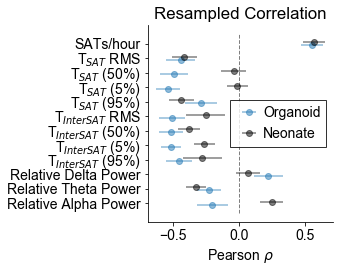

In [6]:
feat_names_abr = [
    'SATs/hour',
    'T$_{SAT}$ RMS',
    'T$_{SAT}$ (50%)',
    'T$_{SAT}$ (5%)',
    'T$_{SAT}$ (95%)',
    'T$_{InterSAT}$ RMS',
    'T$_{InterSAT}$ (50%)',
    'T$_{InterSAT}$ (5%)',
    'T$_{InterSAT}$ (95%)',
    'Relative Delta Power',
    'Relative Theta Power',
    'Relative Alpha Power'
]

plt.figure(figsize=(5,4))
plt.errorbar(y=np.arange(13,1,-1)-0.1, x=params_org[:,2,:].mean(axis=0), xerr=params_org[:,2,:].std(axis=0), ls='none',marker='.', ms=12, alpha=0.5, label='Organoid')
plt.errorbar(y=np.arange(13,1,-1)+0.1, x=params_baby[:,2,:].mean(axis=0), xerr=params_baby[:,2,:].std(axis=0), ls='none',marker='.', ms=12, color='k', alpha=0.5, label='Neonate')
plt.plot([0,0], plt.ylim(), 'k--',lw=1, alpha=0.5)
plt.yticks(np.arange(len(feat_names_abr),0,-1)+1, feat_names_abr, fontsize=14)
plt.xticks(np.arange(-0.5,1,0.5))
plt.xlabel(r'Pearson $\rho$')
plt.legend(fontsize=14, handletextpad=0)
plt.title('Resampled Correlation')
plt.gca().spines['right'].set_visible(False);plt.gca().spines['top'].set_visible(False);
plt.tight_layout()
plt.savefig(fig_saveout + '6_featcorr_vert.pdf', bbox_inches = 'tight')

### Supplementary: resampled correlation

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


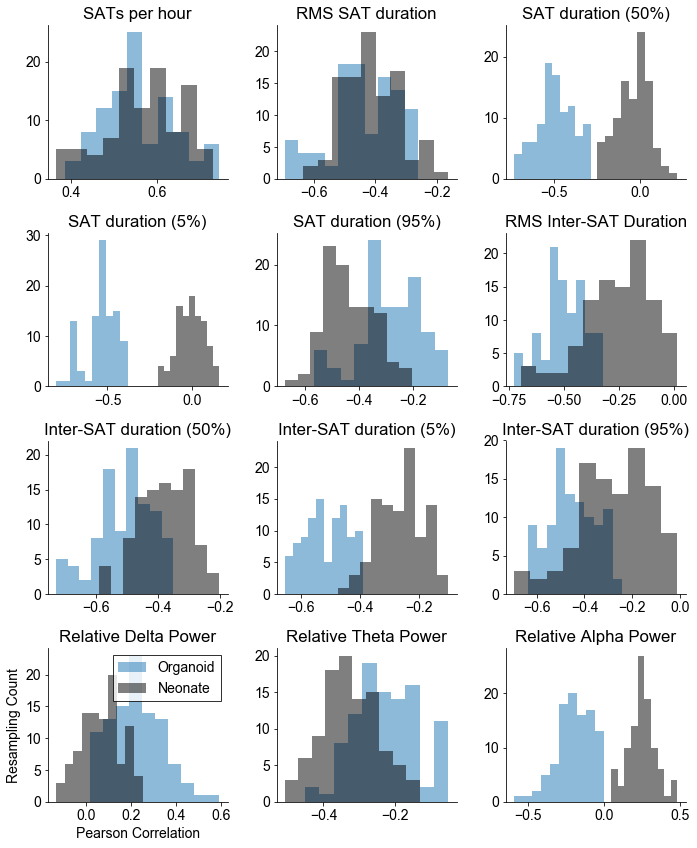

In [7]:
b=2
plt.figure(figsize=(10,12))
for feat in feat_subset:
    plt.subplot(4,3,feat+1)
    plt.hist(params_org[:,b,feat], 10, label='Organoid', alpha=0.5);
    plt.hist(params_baby[:,b,feat], 10, color='k', label='Neonate', alpha=0.5);
    plt.title(feat_names[feat])
    plt.gca().spines['right'].set_visible(False);plt.gca().spines['top'].set_visible(False);

plt.subplot(4,3,10)
plt.xlabel('Pearson Correlation')
plt.ylabel('Resampling Count')
plt.legend()
plt.tight_layout()
plt.savefig(fig_saveout + 'supp_resampledcorr.pdf', bbox_inches = 'tight')

# PAPER FIGURE 5C
### Regularized regression (elastic net)
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#


More specifically, the optimization objective is:
```
1 / (2 * n_samples) * ||y - Xw||^2_2
+ alpha * l1_ratio * ||w||_1
+ 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2
```

If you are interested in controlling the L1 and L2 penalty separately, keep in mind that this is equivalent to:
```
a * L1 + b * L2
```
for:
```
alpha = a + b and l1_ratio = a / (a + b).
```

Note on R2 score:


$R^2 = 1- \frac{SS_{pred}}{SS_{bar}}$ , where 

$$ SS_{pred} =  \sum (y_i - \hat{y_i}) $$ and
$$ SS_{bar} =  \sum (y_i - \bar{y_i}) $$


In [78]:
np.random.seed(0)

# setting up data
train_set = 'baby'
feat_subset = range(len(feat_names_abr))
print('Training on: ' + train_set)

# define training data & id
train_x, train_y, train_id, test_x, test_y, test_id = get_preproc_datasets(
    baby_feat, baby_pma, baby_id, 
    org_feat_stacked, org_age_stacked, org_id_stacked,
    train_set=train_set, feat_cols=feat_cols[feat_subset], age_range=(1,40))

# split training set into train and held-out set
n_samples = train_y.shape[0]
n_heldout = int(n_samples*0.1)
heldout_inds = np.sort(np.random.choice(n_samples, n_heldout, replace=False))
train_inds = np.setdiff1d(np.arange(n_samples), heldout_inds)
heldout_x, heldout_y = train_x[heldout_inds,:], train_y[heldout_inds]
train_x, train_y, train_id = train_x[train_inds,:], train_y[train_inds], train_id[train_inds]

# cross-validation iterator
if train_set is 'baby':
    n_splits = 200
    val_size = 0.4
    cv_splitter = model_selection.GroupShuffleSplit(
        n_splits=n_splits, test_size=val_size).split(train_x, train_y, train_id)
elif train_set is 'organoid':
    val_size = 2
    cv_splitter = model_selection.LeavePGroupsOut(
        n_groups=val_size).split(train_x, train_y, train_id)


# elastic net with grid search on alpha and L1_ratio
l1_ratios = np.arange(0.05,1,0.05)
alphas = np.logspace(-3, 2, 10)
model = linear_model.ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=cv_splitter, normalize=False)

# fit
model.fit(train_x, train_y)
print("Model L1 ratio: %.2f, Model alpha: %.4f" % (model.l1_ratio_, model.alpha_))
print('Model R^2 score on training: %.4f' %model.score(train_x,train_y))
print('Model prediction correlation on training: %.4f, %.4f'%stats.pearsonr(model.predict(train_x), train_y))
print_model_weights(model, np.array(feat_names)[feat_subset])

Training on: baby
Model L1 ratio: 0.95, Model alpha: 0.0010
Model R^2 score on training: 0.5852
Model prediction correlation on training: 0.7662, 0.0000
------- Feature Weights: ------
Constant: : 53.93093
SATs per hour: 0.05791
RMS SAT duration: 0.17439
SAT duration (50%): 0.46857
SAT duration (5%): -1.59115
SAT duration (95%): -0.17140
RMS Inter-SAT Duration: 1.01745
Inter-SAT duration (50%): -1.67926
Inter-SAT duration (5%): 0.00000
Inter-SAT duration (95%): -0.24631
Relative Delta Power: -31.94628
Relative Theta Power: -39.72896
Relative Alpha Power: 30.92235


0.05
---
Mean squared error: 1200.868
R2 score: -12.374
Correlation Coef: 0.63, P-Value: 0.00000
Variance normalized R2 score: 0.269
R2 score for heldout neonates: 0.552


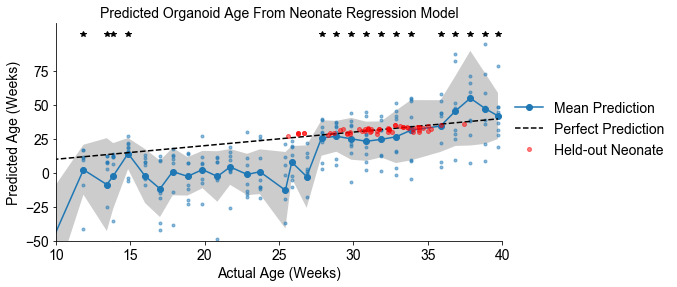

In [108]:
# do prediction & plot
predict_on_testset(model, test_x, test_y, figsize=(8,4)) 
print('Variance normalized R2 score: %.3f'%r2_score(stats.zscore(test_y), stats.zscore(model.predict(test_x))))

# plot prediction on held-out data
plt.plot(heldout_y, model.predict(heldout_x), 'r.', ms=8, alpha=0.5, label='Held-out Neonate')
print('R2 score for heldout neonates: %.3f'%r2_score(heldout_y, model.predict(heldout_x)))


# append to plot
plt.ylim([-50, 110])
plt.yticks(range(-50,100,25))
plt.xlabel('Actual Age (Weeks)')
plt.ylabel('Predicted Age (Weeks)')
plt.xlim([10, 40])
plt.title('Predicted Organoid Age From Neonate Regression Model', fontsize=14);
plt.legend(bbox_to_anchor=[1.0,0.7], frameon=False)
plt.gca().spines['right'].set_visible(False);plt.gca().spines['top'].set_visible(False);
#plt.savefig(fig_saveout + '6_ageprediction.pdf', bbox_inches = 'tight')


# Shuffle prediction age and perform correlation

In [103]:
n_shuffles = 1000
shuffle_stats = np.zeros((n_shuffles,2))
for i in range(n_shuffles):
    shuffle_stats[i,:]=stats.pearsonr(predicted_y, np.random.permutation(test_y))

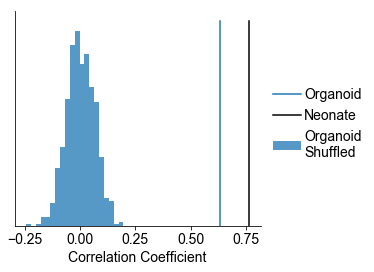

In [359]:
plt.figure(figsize=(4,4))
plt.hist(shuffle_stats[:,0],20, alpha=0.75, label='Organoid\nShuffled')
YL=plt.ylim()
plt.plot([stats.pearsonr(test_y, predicted_y)[0]]*2, YL, '-', color=CKEYS[0], label='Organoid')
plt.plot([stats.pearsonr(train_y, model.predict(train_x))[0]]*2, YL, '-k', label='Neonate')
plt.gca().spines['right'].set_visible(False);plt.gca().spines['top'].set_visible(False);
plt.xlabel('Correlation Coefficient')
plt.yticks([])
plt.legend(loc='best', handletextpad=0.2, bbox_to_anchor=[1.0,0.7], frameon=False)
plt.tight_layout()
plt.savefig(fig_saveout + '6_shuffledcorr.pdf', bbox_inches = 'tight')

### Prediction and plotting with the new architecture

In [327]:
# mouse primary culture prediction
# I have no idea what their actual age is supposed to be: days in vitro? days in embryo?
mpc_path = '/Users/rdgao/Documents/data/Muotri/Spencer/'

mpc_df = pd.DataFrame()
for ds in ['1', '2']:
    mpc_feat = io.loadmat(mpc_path+'mpc'+ds+'_EMAfeatures.mat', squeeze_me=True)
    mpc_df = mpc_df.append(stack_features(mpc_feat['mpc_EMAfeatures'][:,:,feat_cols[feat_subset]], mpc_feat['dayVec'], feat_names=np.array(feat_names)[feat_subset]))
    
# do prediction & insert insert predicted age 
mpc_df.insert(2, 'pred_age', model.predict(mpc_df.iloc[:,2:]))

# heldout neonate data prediction
heldout_df = pd.DataFrame(np.hstack([heldout_y[:,None], heldout_x]), columns=np.hstack(['Age', np.array(feat_names)[feat_subset]]))
heldout_df.insert(2, 'pred_age', model.predict(heldout_df.iloc[:,1:]))

# organoid prediction
org_df = stack_features(org_feat[:,:,feat_cols[feat_subset]], org_age, feat_names=np.array(feat_names)[feat_subset])
org_df.insert(2, 'pred_age', model.predict(org_df.iloc[:,2:]))

**** **** **** ****
--- Per-sample stats ---
MSE: 1200.868
R2 score: -12.374
Standardized R2 score: 0.269
Correlation Coef: 0.63, P-Value: 0.00000
--- Mean prediction stats ---
MSE: 723.739
R2 score: -6.757
Standardized R2 score: 0.748
Correlation Coef: 0.87, P-Value: 0.00000
**** **** **** ****
--- Per-sample stats ---
MSE: 649.448
R2 score: -29.151
Standardized R2 score: 0.151
Correlation Coef: 0.58, P-Value: 0.00000
--- Mean prediction stats ---
MSE: 219.715
R2 score: -9.200
Standardized R2 score: 0.774
Correlation Coef: 0.89, P-Value: 0.00001
**** **** **** ****
--- Per-sample stats ---
MSE: 3.207
R2 score: 0.552
Standardized R2 score: 0.488
Correlation Coef: 0.74, P-Value: 0.00000
--- Mean prediction stats ---
MSE: 2.630
R2 score: 0.662
Standardized R2 score: 0.631
Correlation Coef: 0.82, P-Value: 0.00000


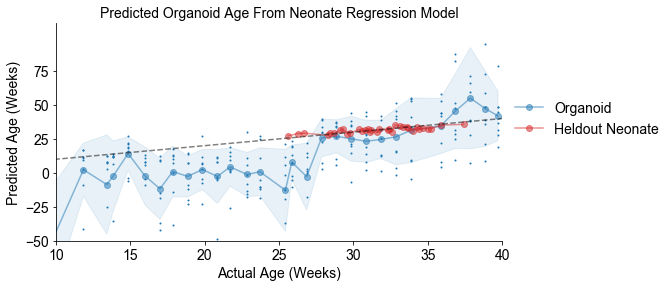

In [358]:
plt.figure(figsize=(8,4))
plot_pred(org_df,CKEYS[0], 'Organoid')
plot_pred(heldout_df,CKEYS[3], 'Heldout Neonate',plot_individual=False)
plt.plot([0,40],[0,40],'k--', alpha=0.5)
plt.ylim([-50, 110])
plt.yticks(range(-50,100,25))
plt.xlabel('Actual Age (Weeks)')
plt.ylabel('Predicted Age (Weeks)')
plt.xlim([10, 40])
plt.title('Predicted Organoid Age From Neonate Regression Model', fontsize=14);
plt.legend(bbox_to_anchor=[1.0,0.7], frameon=False)

pred_stats(org_df)
pred_stats(org_df[org_df['Age']>=25.])
pred_stats(heldout_df)

#plt.savefig(fig_saveout + '6_ageprediction.pdf', bbox_inches = 'tight')

In [351]:
def stack_features(data_x, data_y, remove_nans=True, return_df=True, feat_names=None):
    # stack features along repeats, original dimensions are (session x repeats x feature)
    data_x_stacked = np.reshape(data_x, (np.prod(data_x.shape[:2]), data_x.shape[2]))
    data_y_stacked = np.repeat(data_y, data_x.shape[1])
    id_stacked = np.reshape(np.matmul(np.ones((data_x.shape[0],1)), np.expand_dims(np.arange(data_x.shape[1]),0)), -1)

    if remove_nans:
        # drop rows with any nans in the feature matrix
        clean_inds = np.where(~np.isnan(data_x_stacked).any(axis=1))[0]
        data_x_stacked, data_y_stacked, id_stacked = data_x_stacked[clean_inds, :], data_y_stacked[clean_inds], id_stacked[clean_inds]

    if return_df:
        return pd.DataFrame(np.hstack([data_y_stacked[:,None], id_stacked[:,None], data_x_stacked]), 
            columns=np.concatenate([['Age', 'ID'], feat_names]))
    else:            
        return data_x_stacked, data_y_stacked, id_stacked
    
def plot_pred(df_feat, color, label, plot_individual=True):
    if plot_individual:
        # plot individual samples
        plt.plot(df_feat['Age'], df_feat['pred_age'], '.', ms=2, label='')
    
    # plot mean & std
    true_age = df_feat.groupby('Age', as_index=False).mean()['Age']
    pred_mean = df_feat.groupby('Age', as_index=False).mean()['pred_age']
    pred_std = df_feat.groupby('Age', as_index=False).std()['pred_age']   
    plt.fill_between(true_age, pred_mean-pred_std, pred_mean+pred_std, facecolor=color, edgecolor=color, alpha=0.1, label='')
    plt.plot(true_age, pred_mean, '.-', color=color, ms=12, alpha=0.5, label=label)
    plt.xlabel('True Age (Weeks)')
    plt.ylabel('Predicted Age (Weeks)')
    plt.gca().spines['right'].set_visible(False);plt.gca().spines['top'].set_visible(False);

def pred_stats(df_feat):
    true_age = df_feat.groupby('Age', as_index=False).mean()['Age']
    pred_mean = df_feat.groupby('Age', as_index=False).mean()['pred_age']
    pred_std = df_feat.groupby('Age', as_index=False).std()['pred_age']   
    print('**** **** **** ****')
    print('--- Per-sample stats ---')
    print("MSE: %.3f" % mean_squared_error(df_feat['Age'], df_feat['pred_age']))
    print("R2 score: %.3f" % r2_score(df_feat['Age'], df_feat['pred_age']))
    print('Standardized R2 score: %.3f'%r2_score(stats.zscore(df_feat['Age']), stats.zscore(df_feat['pred_age'])))
    print("Correlation Coef: %.2f, P-Value: %.5f" % sp.stats.pearsonr(df_feat['Age'], df_feat['pred_age']))

    print('--- Mean prediction stats ---')
    print("MSE: %.3f" % mean_squared_error(true_age, pred_mean))
    print("R2 score: %.3f" % r2_score(true_age, pred_mean))
    print('Standardized R2 score: %.3f'%r2_score(stats.zscore(true_age), stats.zscore(pred_mean)))
    print("Correlation Coef: %.2f, P-Value: %.5f" % sp.stats.pearsonr(true_age, pred_mean))